In [101]:
from collections import Counter, defaultdict
import pandas as pd
import numpy as np
from scipy.stats import binomtest
import seaborn as sns
import matplotlib.pyplot as plt

In [102]:
## Data needed: (1) Eggnog mapper results; specifically file with extension .annotations, i.e. the tab-delimited file.
## (2) The list of DEGs in two distinct files. In this example we have two files 'Upregulated.txt' and 'Downregulated.txt'
egg = pd.read_csv('Data/out.emapper.annotations', sep='\t', comment='#', names=['query','seed_ortholog','evalue','score','eggNOG_OGs','max_annot_lvl','COG_category','Description','Preferred_name','GOs','EC','KEGG_ko','KEGG_Pathway','KEGG_Module','KEGG_Reaction','KEGG_rclass','BRITE','KEGG_TC','CAZy','BiGG_Reaction','PFAMs'
])
upreg, downreg = np.loadtxt('Data/Upregulated.txt', dtype='U'), np.loadtxt('Data/Downregulated.txt', dtype='U')
print(Counter(egg['COG_category'].to_list()))


Counter({'S': 696, '-': 289, 'E': 210, 'J': 199, 'L': 186, 'K': 185, 'M': 182, 'C': 174, 'P': 158, 'T': 154, 'O': 123, 'H': 110, 'I': 95, 'G': 82, 'F': 76, 'D': 53, 'U': 52, 'N': 46, 'V': 45, 'Q': 39, 'NU': 37, 'IQ': 30, 'NT': 18, 'KT': 17, 'EG': 13, 'EH': 9, 'EGP': 9, 'EU': 6, 'CO': 6, 'GM': 6, 'CH': 5, 'MU': 5, 'JKL': 4, 'CP': 4, 'OU': 3, 'KLT': 3, 'FJ': 3, 'KL': 3, 'BQ': 2, 'ET': 2, 'FG': 2, 'LU': 1, 'FP': 1, 'NPTU': 1, 'NOU': 1, 'A': 1, 'CI': 1, 'IM': 1, 'QU': 1, 'HJ': 1, 'EJ': 1, 'KO': 1, 'PT': 1, 'PQ': 1, 'EP': 1, 'CF': 1, 'DZ': 1, 'CG': 1, 'HP': 1, 'CM': 1, 'JM': 1, 'MN': 1, 'CE': 1, 'MNU': 1, 'EM': 1, 'DT': 1, 'IT': 1})


In [103]:
def calc_background(column):
    ## Add +1 to COG categories assigned to any gene
    bg = defaultdict(int)
    for entry in column:
        for x in entry:
            bg[x] += 1
    return dict(bg)

In [104]:
bg = calc_background(egg['COG_category'])
# Categories 'S', 'R' and '-' are unknown | general prediction only
bg = {k:v for k,v in bg.items() if k not in {'S', 'R', '-'}}
bg = dict(sorted(bg.items(), key=lambda item: item[1], reverse=True))
bg

{'E': 253,
 'K': 213,
 'J': 209,
 'M': 199,
 'T': 198,
 'L': 197,
 'C': 194,
 'P': 177,
 'O': 134,
 'I': 128,
 'H': 126,
 'G': 113,
 'U': 108,
 'N': 105,
 'F': 83,
 'Q': 73,
 'D': 55,
 'V': 45,
 'B': 2,
 'A': 1,
 'Z': 1}

In [105]:
# Add informative labels
labels = {'J':'J - Translation, ribosomal structure and biogenesis','A':'A - RNA processing and modification','K':'K - Transcription',
          'L':'L - Replication, recombination and repair','B':'B - Chromatin structure and dynamics',
          'D':'D - Cell cycle control, cell division, chromosome partitioning','Y':'Y - Nuclear structure','V':'V - Defense mechanisms',
          'T':'T - Signal transduction mechanisms','M':'M - Cell wall/membrane/envelope biogenesis','N':'N - Cell motility',
          'Z':'Z - Cytoskeleton','W':'W - Extracellular structures','U':'U - Intracellular trafficking, secretion, and vesicular transport',
          'O':'O - Posttranslational modification, protein turnover, chaperones','X':'X - Mobilome: prophages, transposons',
          'C':'C - Energy production and conversion','G':'G - Carbohydrate transport and metabolism','E':'E - Amino acid transport and metabolism',
          'F':'F - Nucleotide transport and metabolism','H':'H - Coenzyme transport and metabolism','I':'I - Lipid transport and metabolism',
          'P':'P - Inorganic ion transport and metabolism','Q':'Q - Secondary metabolites biosynthesis, transport and catabolism',
          'R':'R - General function prediction only','S':'S - Function unknown'}

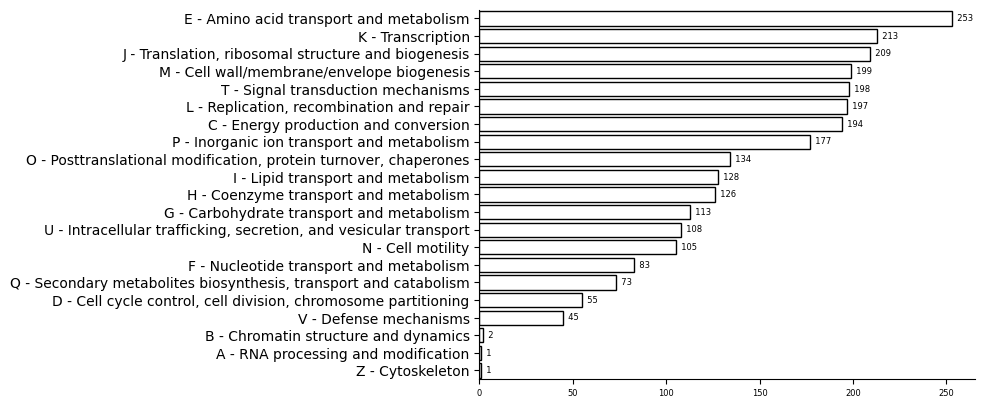

In [106]:
sns.barplot(x=bg.values(), y=[labels[x] for x in bg.keys()], edgecolor='black', linewidth=1, color='white')
plt.xticks(rotation=0, size=6)
sns.despine()
for index, value in enumerate(bg.values()):
    plt.text(value, index, f'  {value}', va='center', size=6)

In [107]:
## The binomial test is a test of the null hypothesis that the probability of success in a Bernoulli experiment is p.
## In our case we test each COG category using k (number of successes), n (number of trials) and p (probability of success)
## The number of successes is the number of times that COG category is present in, say, the overexpressed genes.
## The number of trials is the total number of times the $i$-th COG category is differentially expressed.
## The probability of success is the empirical probability estimated using the observed ratios of COGs over all categories.

In [108]:
## Proceed in order. 
## (1) For every COG category i, calculate the empirical probability p
p_i = {}
p_i = {k:v/sum(bg.values()) for k,v in bg.items()}

## (2) Calculate the number of trials n
"""
Note: I like to submit protein sequences with a modified header (locus tag, @, protein identifier)
    >PSHAa0001@CAI85115.1
    MMCGNKNYISGSLTVYLSVWQSCLYVLQDELPSQQFSMWVRPLQAESTEDTLTIYAPNRFVLDWVREKYLNRINELLVEI
    ...
    >PSHAa0002@CAI85116.1
    MQITISRQQFLKPLVQVSGAIERKHTLPILSNVLLAVENGQLSMTGTDLEIELVASVFVGDDIADTKLTLPAKKLLDICK
    ...
Therefore, the following few lines of code assume the gene names in the Eggnog mapper results file to be formatted this way.
"""

DEGs = list(upreg) + list(downreg)
queries = [x for x in egg['query'] if x.split('@')[0] in DEGs] ## Genes in the egg dataframe that are DE
n_i = calc_background(egg.loc[(egg['query'].isin(queries)), 'COG_category']) ## Counts of COG categories only among the DEG (n for each i-th category)

## (3) For every COG category i, calculate the number of successes k (Upregulation given the condition)
up_k_i = {}
queries = [x for x in egg['query'] if x.split('@')[0] in upreg]
up_k_i = calc_background(egg.loc[(egg['query'].isin(queries)), 'COG_category'])
up_k_i = {k:v for k,v in up_k_i.items() if k not in {'S', 'R', '-'}}

## (4) For every COG category i, calculate the number of successes k (Downregulation given the condition)
down_k_i = {}
queries = [x for x in egg['query'] if x.split('@')[0] in downreg]
down_k_i = calc_background(egg.loc[(egg['query'].isin(queries)), 'COG_category'])
down_k_i = {k:v for k,v in down_k_i.items() if k not in {'S', 'R', '-'}}

In [109]:
## Now perform the statistical test
alpha = 0.01
for category in bg.keys():
    #E, K, J . . . etc
    k_u, k_d, n, p = 0, 0, 0, 0
    if category not in p_i or category not in n_i:
        continue # If the category is not in background we cannot test the hypothesis for this COG
    if category in up_k_i:
        k_u = up_k_i[category]
    if category in down_k_i:
        k_d = down_k_i[category]
    n, p = n_i[category], p_i[category]
    pvalue_u = binomtest(k_u, sum(up_k_i.values()), p, alternative='greater').pvalue
    pvalue_d = binomtest(k_d, sum(down_k_i.values()), p, alternative='greater').pvalue
    signif_u, signif_d = 'n.s.', 'n.s.'
    #print(category, pvalue_u, pvalue_d)
    if pvalue_u < alpha: signif_u = '*'
    if pvalue_d < alpha: signif_d = '*'
    print(category, signif_u, signif_d)

E n.s. *
K n.s. n.s.
J n.s. *
M * n.s.
T * n.s.
L * n.s.
C n.s. *
P n.s. n.s.
O n.s. *
I n.s. n.s.
H n.s. n.s.
G n.s. n.s.
U * n.s.
N * n.s.
F n.s. n.s.
Q n.s. n.s.
D n.s. n.s.
V n.s. n.s.
